In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=(224,224,3))
])

Change link according to the location on the drive

In [10]:
data_dir = '/content/drive/MyDrive/dataset/map'

In [11]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/drive/MyDrive/dataset/map')

In [13]:
image_count = len(list(data_dir.glob('*/*.jpg')))+ len(list(data_dir.glob('*/*.jpeg')))+ len(list(data_dir.glob('*/*.png')))
image_count

1000

In [14]:
map_img_dict = {
    'water' : list(data_dir.glob('water/*')),
    'desert': list(data_dir.glob('desert/*')),
    'cloudy': list(data_dir.glob('cloudy/*')),
    'green_area': list(data_dir.glob('green_area/*'))
}

In [15]:
map_label_dict = {
    'water' : 0,
    'desert': 1,
    'cloudy': 2,
    'green_area': 3
}

In [16]:
x,y = [], []

for map_image, images in map_img_dict.items():
    for image in images: 
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (224,224))
        x.append(resized_img)
        y.append(map_label_dict[map_image])

x = np.array(x);
y = np.array(y);

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [18]:
x_train = x_train/255
x_test= x_test/255

In [19]:
model = tf.keras.models.Sequential()

In [20]:
model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(224,224,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3), activation='relu'))

In [21]:
model.add(layers.Flatten())
model.add(layers.Dense(100,activation='relu'))
model.add(layers.Dense(4))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        9248      
                                                                 
 flatten (Flatten)           (None, 86528)            

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test,y_test))

Epoch 1/10
22/22 [==============================] - 44s 2s/step - loss: 1.6297 - accuracy: 0.4071 - val_loss: 0.7733 - val_accuracy: 0.6667
Epoch 2/10
22/22 [==============================] - 43s 2s/step - loss: 0.5920 - accuracy: 0.7200 - val_loss: 0.5220 - val_accuracy: 0.7633
Epoch 3/10
22/22 [==============================] - 43s 2s/step - loss: 0.4712 - accuracy: 0.7843 - val_loss: 0.5775 - val_accuracy: 0.6967
Epoch 4/10
22/22 [==============================] - 43s 2s/step - loss: 0.4705 - accuracy: 0.7786 - val_loss: 0.5245 - val_accuracy: 0.8100
Epoch 5/10
22/22 [==============================] - 43s 2s/step - loss: 0.4901 - accuracy: 0.7929 - val_loss: 0.4495 - val_accuracy: 0.8333
Epoch 6/10
22/22 [==============================] - 42s 2s/step - loss: 0.4235 - accuracy: 0.8229 - val_loss: 0.3706 - val_accuracy: 0.8567
Epoch 7/10
22/22 [==============================] - 43s 2s/step - loss: 0.4934 - accuracy: 0.7514 - val_loss: 0.4905 - val_accuracy: 0.8167
Epoch 8/10
22/22 [==

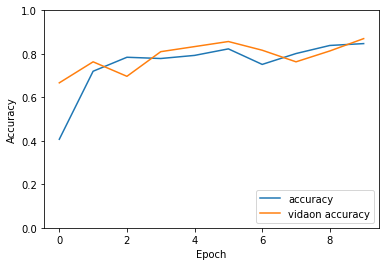

In [24]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'],label='vidaon accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [25]:
test_loss, test_acc = model.evaluate(x_test,  y_test)

10/10 [==============================] - 5s 450ms/step - loss: 0.3533 - accuracy: 0.8700


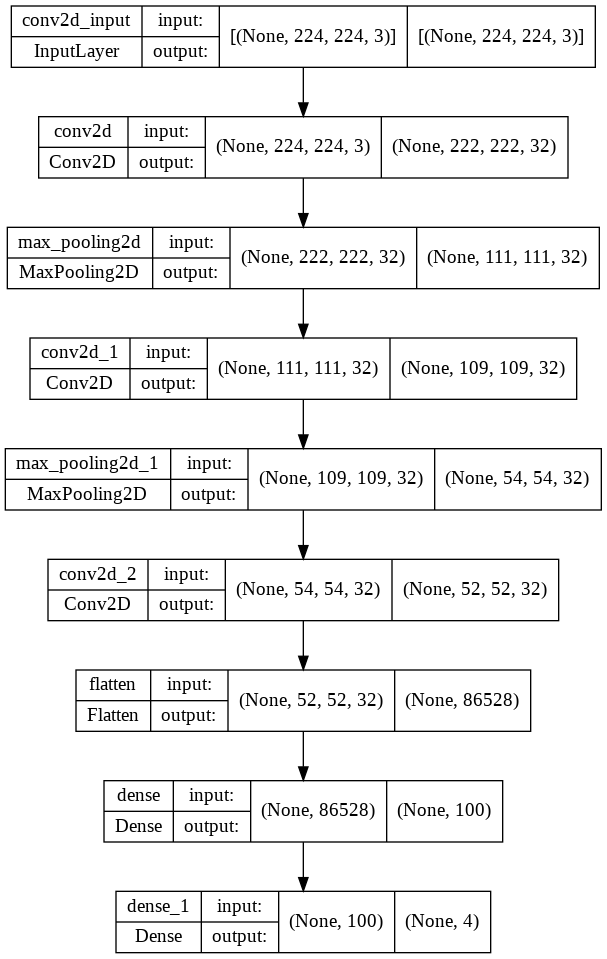

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Not the best model to use so try another

In [27]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrained_model_without_top_layer = hub.KerasLayer(feature_extractor_model, input_shape=(224, 224, 3), trainable=False)


In [28]:
model = tf.keras.Sequential([ 
                    pretrained_model_without_top_layer, 
                    tf.keras.layers.Dense(4)
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [29]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

model.fit(x_train, y_train, epochs=5)

Epoch 1/5
22/22 [==============================] - 26s 978ms/step - loss: 0.5971 - acc: 0.8357
Epoch 2/5
22/22 [==============================] - 21s 933ms/step - loss: 0.1397 - acc: 0.9800
Epoch 3/5
22/22 [==============================] - 19s 873ms/step - loss: 0.0890 - acc: 0.9886
Epoch 4/5
22/22 [==============================] - 20s 922ms/step - loss: 0.0686 - acc: 0.9900
Epoch 5/5
22/22 [==============================] - 20s 901ms/step - loss: 0.0587 - acc: 0.9871


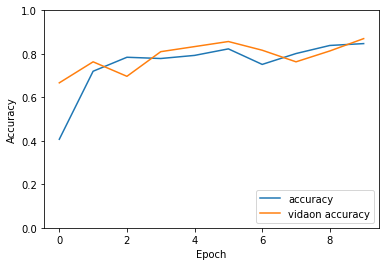

In [30]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'],label='vidaon accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [31]:
test_loss, test_acc = model.evaluate(x_test,  y_test)

10/10 [==============================] - 9s 857ms/step - loss: 0.0919 - acc: 0.9700
